# Manhattan reconstruction
The manhattan have been used to calibrate the camera. By using the projection of each tower on each camera, we should be able to reconstruct the manhattan tower position. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%load_ext autoreload
%autoreload 2
from btracker.io import opencv as opencv_io
from btracker.io import ivfile as ivfile_io


from btracker.triangulate import triangulate_ncam_pairwise, triangulate_multiview


## Load calibration

In [2]:
# Load the camera calibration
filename_fullcalib = '/media/bolirev/BOMBUS_SYLV/Calibrations/20180118_checkerboard/calibration.xml'
cameras_calib = opencv_io.load_cameras_calibration(filename_fullcalib)
ncams = len(cameras_calib)

FileNotFoundError: [Errno 2] No such file or directory: '/media/bolirev/BOMBUS_SYLV/Calibrations/20180118_checkerboard/calibration.xml'

## Load the 3d manhattan

In [3]:
# the manhattan created in pandas and saved in hdf
manhattan_filename = 'manhattan_0001.hdf'
manhattan_3d = pd.read_hdf(manhattan_filename, 'manhattan')

## Load the 2d manhattans

In [11]:
# Load the manhattans 
corner_th = 60
template_manhattans = '/media/bolirev/BOMBUS_SYLV/Calibrations/20180118_checkerboard/Manhattans/cam_{}.tra'
filenames = dict()
for cam_i in range(ncams):
    filenames[cam_i]=template_manhattans.format(cam_i)

pts_cam_dict = dict()
for cam_i in range(ncams):
    pts_cam_dict[cam_i]=ivfile_io.manhattan(filenames[cam_i], corner_th)
    
manhattans = pd.concat(pts_cam_dict.values(), axis=1, keys=pts_cam_dict.keys())
manhattans = manhattans.dropna(how='all')

pts_cam = list()
for cam_i in range(ncams):
    pts_cam.append(manhattans.loc[:,(cam_i,['x','y'])].values)
pts_cam=np.array(pts_cam)

## Triangulate

In [20]:
pts_3d = triangulate_ncam_pairwise(cameras_calib, pts_cam)
pts_3d = pd.DataFrame(data=pts_3d, columns = ['x','y','z'], index=manhattans.index)
pts_3d = pts_3d.dropna()
pts_3d.head()

/home/bolirev/.virtualenvs/toolbox-tracking/lib/python3.6/site-packages/btracker-0.1-py3.6.egg/btracker/triangulate/__init__.py:86: RuntimeWarning: invalid value encountered in true_divide


,x,y,z
1,29.031127,-130.040608,247.605996
2,29.033310,-130.029942,247.618826
3,29.035662,-130.019642,247.632042
4,29.046246,-130.065821,247.458300
5,29.054001,-130.075993,247.495957


In [22]:
pts_cam_projected.shape

(3, 22, 2)

In [38]:
from btracker.triangulate.tools import projects_points
pts_cam_tmp = projects_points(pts_3d.loc[:,['x','y','z']].values, cameras_calib)
pts_cam_projected = pd.DataFrame(data=np.nan, 
                                 columns = pd.MultiIndex.from_product([range(ncams),
                                     ['x','y']]), 
                                 index=pts_3d.index)
for cam_i,data in enumerate(pts_cam_tmp):
    pts_cam_projected.loc[:,(cam_i)]=data
pts_cam_projected.head()

0                         1                        2             
            x            y            x            y           x            y
1 -376.360793  4252.326280  1219.208294  1185.685628  637.818145  1174.491303
2 -376.327927  4252.685064  1219.247862  1185.570010  637.863290  1174.418522
3 -376.305330  4253.074174  1219.288037  1185.456045  637.874957  1174.379671
4 -374.974754  4246.667572  1219.276864  1186.388571  642.889556  1169.747721
5 -375.571992  4248.780216  1219.318222  1186.350358  640.866875  1171.750947

In [50]:
cam_i = 0
mark_i = 1
distance = (pts_cam_projected.loc[mark_i,(cam_i,'x')] - pts_cam[cam_i,:,0])**2 \
         + (pts_cam_projected.loc[mark_i,(cam_i,'y')] - pts_cam[cam_i,:,1])**2
mark_i = np.nanargmin(distance)
mindist = np.nanmin(distance)
print(mindist)

18224490.7765


In [15]:
cam0mark0

array([ 240.96005862,  838.28367034])

## Plots

(-100, 100)

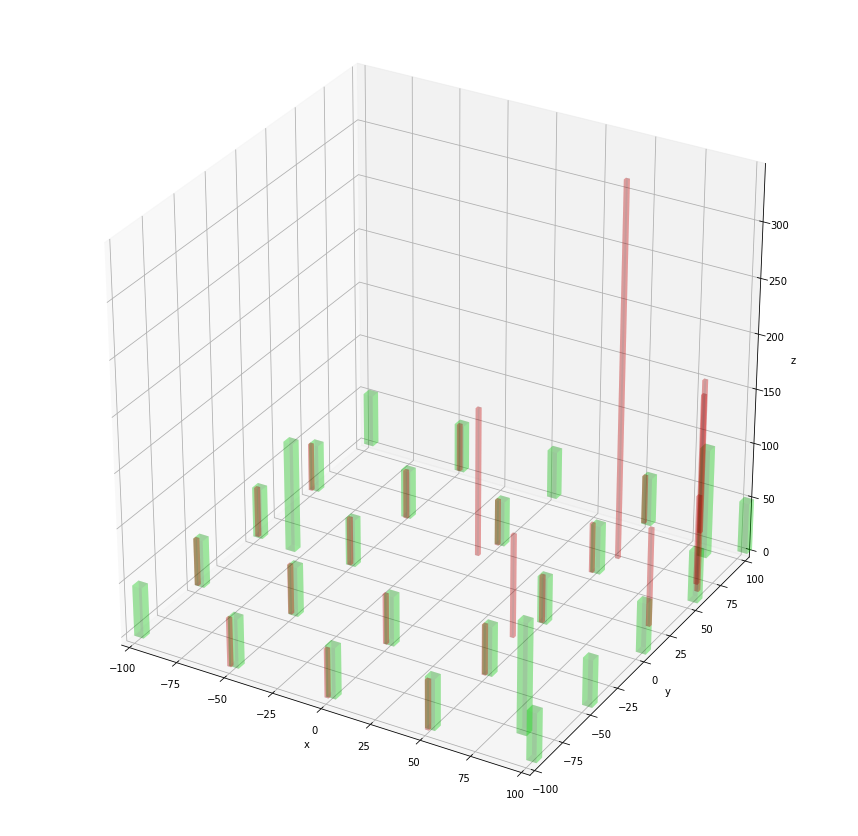

In [10]:
bar_w = 5
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ref = manhattan_3d.dropna()
ax.bar3d(ref.x.values,ref.y.values,0*ref.z.values, 
         dx=bar_w+0*ref.z.values, dy=bar_w+0*ref.z.values, dz=ref.z.values, 
         color=(0.0,1.0,0.0,0.2), zsort='average')

bar_w = 2
ax.bar3d(pts_3d.x.values,pts_3d.y.values,0*pts_3d.z.values, 
         dx=bar_w+0*pts_3d.z.values, dy=bar_w+0*pts_3d.z.values, dz=pts_3d.z.values, 
         color=(1.0,0.0,0.0,0.2), zsort='average')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([ref.x.min(),ref.x.max()])
ax.set_ylim([ref.y.min(),ref.y.max()])